In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 76% 113M/149M [00:00<00:00, 158MB/s] 
100% 149M/149M [00:00<00:00, 174MB/s]


In [3]:
'''
    Function: get_class_paths
    Objective: Load the metadata of a dataset onto a pandas Dataframe,
               and return it.
    Params: file_path (str)
    Returns: df (pd.Dataframe) (containing all the classes with
             respective paths)

'''
def get_class_paths(file_path):
    classes = []
    class_paths = []

    # Iterate through directories in training path
    for label in os.listdir(file_path):
        label_path = os.path.join(file_path, label)
        print(label_path)

        # Check the directory path validity.
        if os.path.isdir(label_path):
            # Iterate through the images in the directory
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)

                # Add the class and path to respective lists
                classes.append(label)
                class_paths.append(image_path)

    # Create a Dataframe with collected data
    df = pd.DataFrame({
        'Class Path': class_paths,
        'Class': classes
    })

    return df



In [4]:
# Create the training and testing dataframes.

# Adjust train and test path based on your specifications.
train_path = '/content/Training'
test_path = '/content/Testing'
train_df = get_class_paths(train_path)
test_df = get_class_paths(test_path)


/content/Training/meningioma
/content/Training/glioma
/content/Training/notumor
/content/Training/pituitary
/content/Testing/meningioma
/content/Testing/glioma
/content/Testing/notumor
/content/Testing/pituitary


In [5]:
train_df

,Class Path,Class
0,/content/Training/meningioma/Tr-me_1245.jpg,meningioma
1,/content/Training/meningioma/Tr-me_0590.jpg,meningioma
2,/content/Training/meningioma/Tr-me_0153.jpg,meningioma
3,/content/Training/meningioma/Tr-me_0130.jpg,meningioma
4,/content/Training/meningioma/Tr-me_0024.jpg,meningioma
...,...,...
5707,/content/Training/pituitary/Tr-pi_1392.jpg,pituitary
5708,/content/Training/pituitary/Tr-pi_1049.jpg,pituitary
5709,/content/Training/pituitary/Tr-pi_0248.jpg,pituitary
5710,/content/Training/pituitary/Tr-pi_0790.jpg,pituitary


In [6]:
test_df

,Class Path,Class
0,/content/Testing/meningioma/Te-me_0208.jpg,meningioma
1,/content/Testing/meningioma/Te-me_0151.jpg,meningioma
2,/content/Testing/meningioma/Te-me_0046.jpg,meningioma
3,/content/Testing/meningioma/Te-me_0112.jpg,meningioma
4,/content/Testing/meningioma/Te-me_0034.jpg,meningioma
...,...,...
1306,/content/Testing/pituitary/Te-pi_0140.jpg,pituitary
1307,/content/Testing/pituitary/Te-pi_0011.jpg,pituitary
1308,/content/Testing/pituitary/Te-pi_0269.jpg,pituitary
1309,/content/Testing/pituitary/Te-piTr_0007.jpg,pituitary


In [7]:
# Import necessary libraries to run experiment
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf

# Building the CNN layer by layer i.e. stacking layers linearly
from tensorflow.keras.models import Sequential
# Layer optimizers to build and train the model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# For data preprocessing
from tensorflow.keras.optimizers import Adamax
# For preprocessing and evaluation
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers


In [8]:
#  Split the testing data into validation and testing sets
# to avoid overfitting issues in the future.

validation_df, testing_df = train_test_split(test_df, train_size=0.5, stratify=test_df['Class'])
# Params explanation (train_test_split): which data, split proportions, proportion of data based on 'Class' attribute


In [9]:
 validation_df

,Class Path,Class
241,/content/Testing/meningioma/Te-me_0098.jpg,meningioma
394,/content/Testing/glioma/Te-gl_0207.jpg,glioma
640,/content/Testing/notumor/Te-no_0021.jpg,notumor
58,/content/Testing/meningioma/Te-me_0016.jpg,meningioma
170,/content/Testing/meningioma/Te-me_0288.jpg,meningioma
...,...,...
865,/content/Testing/notumor/Te-no_0034.jpg,notumor
687,/content/Testing/notumor/Te-no_0255.jpg,notumor
1181,/content/Testing/pituitary/Te-pi_0016.jpg,pituitary
137,/content/Testing/meningioma/Te-me_0173.jpg,meningioma


In [10]:
testing_df

,Class Path,Class
661,/content/Testing/notumor/Te-no_0181.jpg,notumor
593,/content/Testing/glioma/Te-glTr_0005.jpg,glioma
155,/content/Testing/meningioma/Te-me_0222.jpg,meningioma
260,/content/Testing/meningioma/Te-me_0057.jpg,meningioma
561,/content/Testing/glioma/Te-gl_0126.jpg,glioma
...,...,...
458,/content/Testing/glioma/Te-gl_0204.jpg,glioma
341,/content/Testing/glioma/Te-gl_0127.jpg,glioma
1119,/content/Testing/pituitary/Te-pi_0159.jpg,pituitary
1307,/content/Testing/pituitary/Te-pi_0011.jpg,pituitary


In [11]:
# Adjust hyper-parameters and image generators.

# Reduced image size to reduce memory usage during model training
batch_size = 16
test_batch_size = int(batch_size / 2)

image_size = (224, 224)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

augmented_image_generator = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8, 1.2),
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

testing_generator = ImageDataGenerator(rescale=1/255)

train_gen = augmented_image_generator.flow_from_dataframe(
    train_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=image_size
)

validation_gen = augmented_image_generator.flow_from_dataframe(
    validation_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=image_size
)

testing_gen = testing_generator.flow_from_dataframe(
    testing_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=test_batch_size,
    target_size=image_size,
    shuffle=False       # maintain the order for consistent testing procedure.
)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


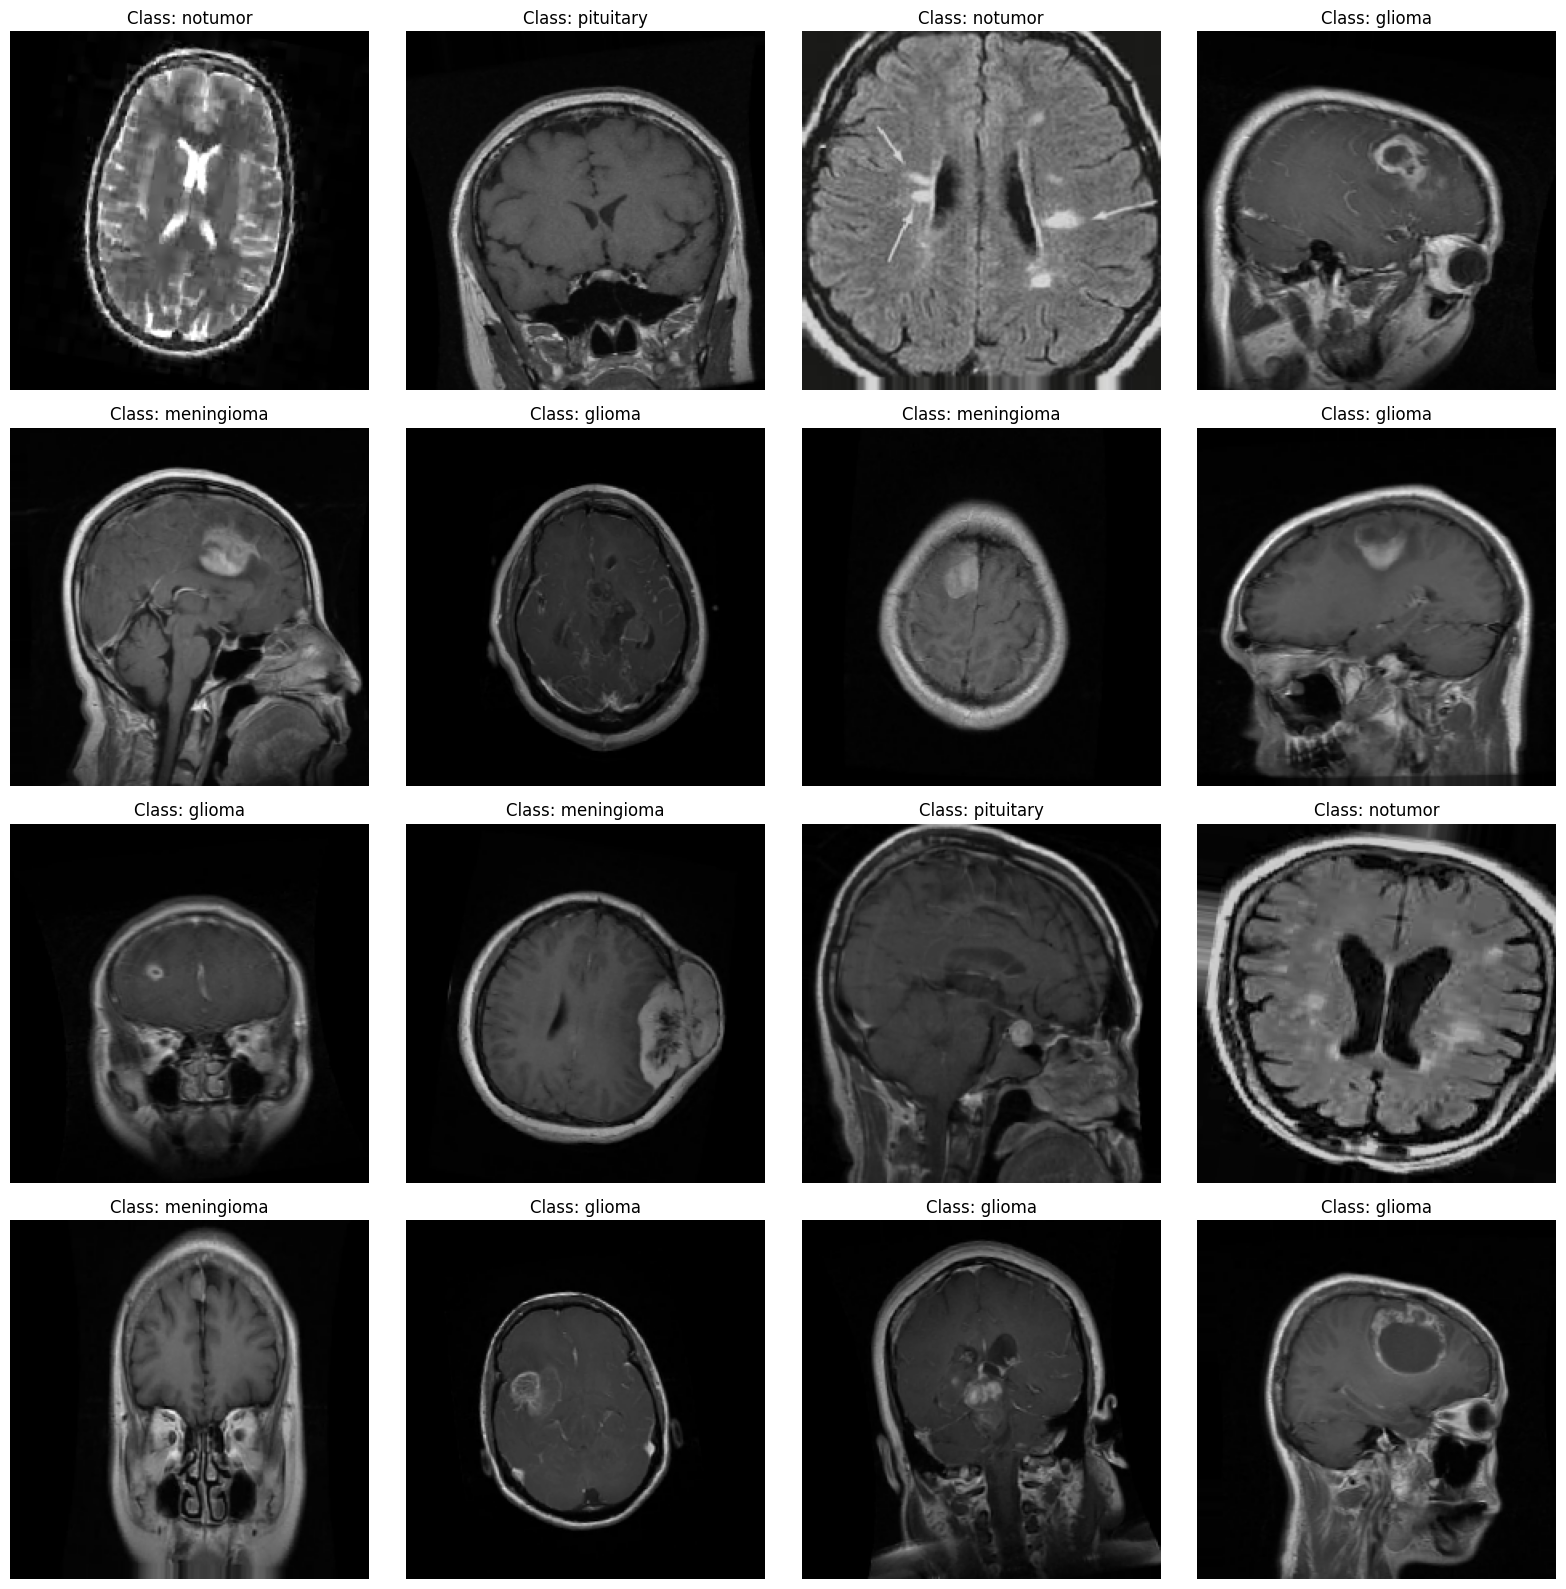

In [12]:
# Viewing preprocessed images

plt.figure(figsize=(16,16))
for idx in range(16):
    # Creating individual subplots
    plt.subplot(4, 4, idx + 1)
    batch = next(train_gen)
    image = batch[0][0]
    label = batch[1][0]
    plt.imshow(image)

    # Retrieve class index
    class_index = np.argmax(label)

    # Retrieve list of class names and class indices
    class_names = list(train_gen.class_indices.keys())
    class_indices = list(train_gen.class_indices.values())

    # Retrieve index of class_index from class_indices list
    class_index_position = class_indices.index(class_index)

    # find the class name from the class index position
    class_name = class_names[class_index_position]

    # Lastly, set title and turn off axes display
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
custom_model = Sequential()
input_shape = (224,224,3)

# Experiment with adding convolutional layers


# 1st Convolutional Layer
custom_model.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape, activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=(2,2)))
custom_model.add(Dropout(0.25))

# 2nd Convolutional Layer
custom_model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=(2,2)))
custom_model.add(Dropout(0.25))

# 3rd Convolutional Layer
custom_model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=(2,2)))
custom_model.add(Dropout(0.25))

# 4th Convolutional Layer
custom_model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
custom_model.add(MaxPooling2D(pool_size=(2,2)))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=(2,2)))
custom_model.add(Dropout(0.25))

# Last Convolutional Layer
custom_model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
# custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D(pool_size=(2,2)))
# custom_model.add(Dropout(0.2))

# Flatten the output for fully connected layers
custom_model.add(Flatten())

# Fully connected layers
# custom_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# custom_model.add(Dropout(0.35))

custom_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
custom_model.add(BatchNormalization())
custom_model.add(Dropout(0.25))

# Add output layer with 4 neurons representative of output classes
custom_model.add(Dense(4, activation='softmax'))

# Compile the model
custom_model.compile(
    Adamax(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', Precision(), Recall()]
)

# Display model summary
custom_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,161,476 (8.25 MB)

 Trainable params: 2,160,260 (8.24 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [14]:
# Running some experiments.
# # Add a model checkpoint call back to store the best weights
# # during training, future use.

# from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint_filepath = 'my_cnn_model.h5'
# model_checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor='val_accuracy',    # or 'val_loss' (or another metric)
#     mode='max',               # or 'min' if monitoring loss like 'val_loss'
#     save_best_only=True,      # saving only the best model
#     save_weights_only=False,  # saving the entire model (structure + weights)
#     verbose=1,
#     save_format="h5",
# )


In [15]:
cm_hist = custom_model.fit(
    train_gen,
    epochs=20,
    validation_data=validation_gen
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 98s 235ms/step - accuracy: 0.6026 - loss: 1.2381 - precision: 0.6672 - recall: 0.5006 - val_accuracy: 0.4290 - val_loss: 3.9249 - val_precision: 0.4323 - val_recall: 0.4290
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 81s 223ms/step - accuracy: 0.7365 - loss: 0.8767 - precision: 0.7820 - recall: 0.6793 - val_accuracy: 0.4504 - val_loss: 3.4471 - val_precision: 0.4485 - val_recall: 0.4458
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 81s 224ms/step - accuracy: 0.7743 - loss: 0.7884 - precision: 0.8071 - recall: 0.7346 - val_accuracy: 0.4992 - val_loss: 3.4059 - val_precision: 0.5015 - val_recall: 0.4992
Epoch 4/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 81s 223ms/step - accuracy: 0.8183 - loss: 0.6791 - precision: 0.8389 - recall: 0.7878 - val_accuracy: 0.5176 - val_loss: 3.1511 - val_precision: 0.5191 - val_recall: 0.5176
Epoch 5/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 80s 222ms/step - accuracy: 0.8427 - loss: 0.5979 - precision: 0.8640 - recall: 0.8204 - val_accuracy: 0.5863 - val_loss

In [16]:
print(f"Metrics needed: {cm_hist.history.keys()}")
metrics_list = list(cm_hist.history.keys())
print(f"The type: {type(metrics_list)} and required metrics: {metrics_list[:4]}")

Metrics needed: dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])
The type: <class 'list'> and required metrics: ['accuracy', 'loss', 'precision', 'recall']


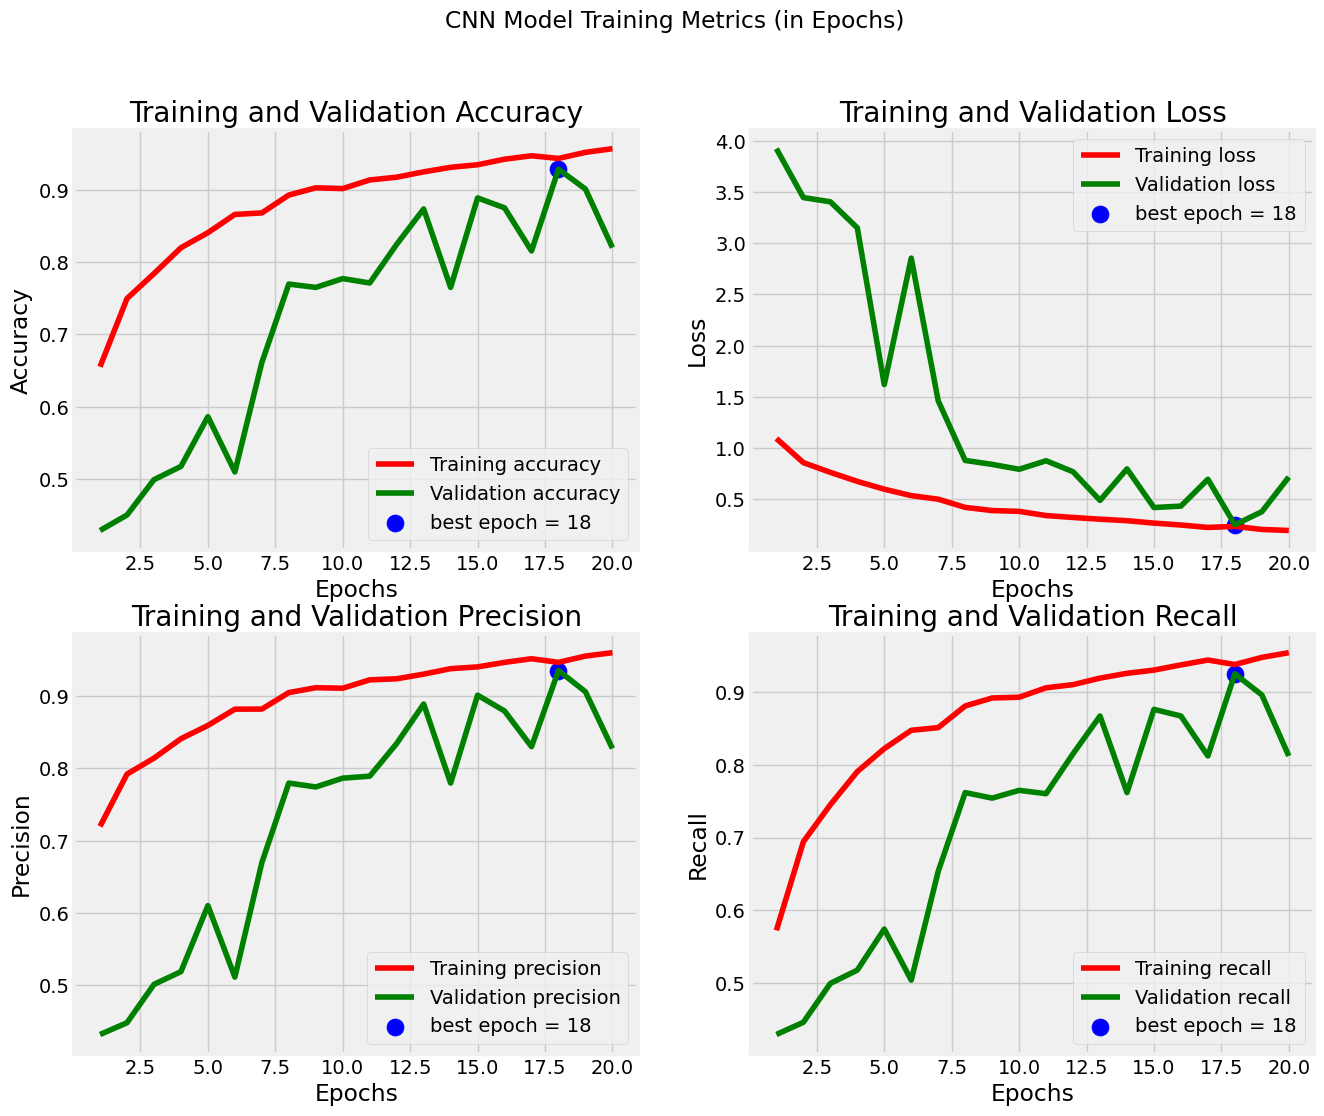

In [17]:
# Getting the training and validation history of our CNN model
# metrics = ['accuracy', 'loss', 'precision_8', 'recall_8']

metrics = metrics_list[:4]
train_metrics = {m: cm_hist.history[m] for m in metrics}
validation_metrics = {m: cm_hist.history[f'val_{m}'] for m in metrics}

# Finding the best epochs and values achieved
best_epochs = {}
best_values = {}

for metric in metrics:
    if metric == 'loss':
        # find the lowest validation loss and store it's index
        idx = np.argmin(validation_metrics[metric])
    else:
        idx = np.argmax(validation_metrics[metric])

    best_epochs[metric] = idx + 1
    best_values[metric] = validation_metrics[metric][idx]


# Plot results
plt.figure(figsize=(16,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, start=1):
    plt.subplot(2, 2, i)
    epochs = range(1, len(train_metrics[metric]) + 1)

    plt.plot(epochs, train_metrics[metric], 'r', label=f'Training {metric}')
    plt.plot(epochs, validation_metrics[metric], 'g', label=f'Validation {metric}')
    plt.scatter(best_epochs[metric], best_values[metric],
                s=150, c='blue', label=f'best epoch = {best_epochs[metric]}')

    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

plt.suptitle('CNN Model Training Metrics (in Epochs)')
plt.show()


In [18]:
# Evaluate model performance on dataset splits - train, test and validation

train_score = custom_model.evaluate(train_gen, verbose=1)
validation_score = custom_model.evaluate(validation_gen, verbose=1)
test_score = custom_model.evaluate(testing_gen, verbose=1)

print(f"Training Accuracy: {train_score[1] * 100:.2f}%")
print(f"Training Loss: {train_score[0]:.4f}")

print(f"\n\nValidation Accuracy: {validation_score[1] * 100:.2f}%")
print(f"Validation Loss: {validation_score[0]:.4f}")

print(f"\n\nTesting Accuracy: {test_score[1] * 100:.2f}%")
print(f"Testing Loss: {test_score[0]:.4f}")


357/357 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - accuracy: 0.8350 - loss: 0.6527 - precision: 0.8469 - recall: 0.8318
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.7990 - loss: 0.8036 - precision: 0.8131 - recall: 0.7936


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7662 - loss: 1.0511 - precision: 0.7725 - recall: 0.7606
Training Accuracy: 83.04%
Training Loss: 0.6822


Validation Accuracy: 80.61%
Validation Loss: 0.7483


Testing Accuracy: 79.27%
Testing Loss: 0.9033


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


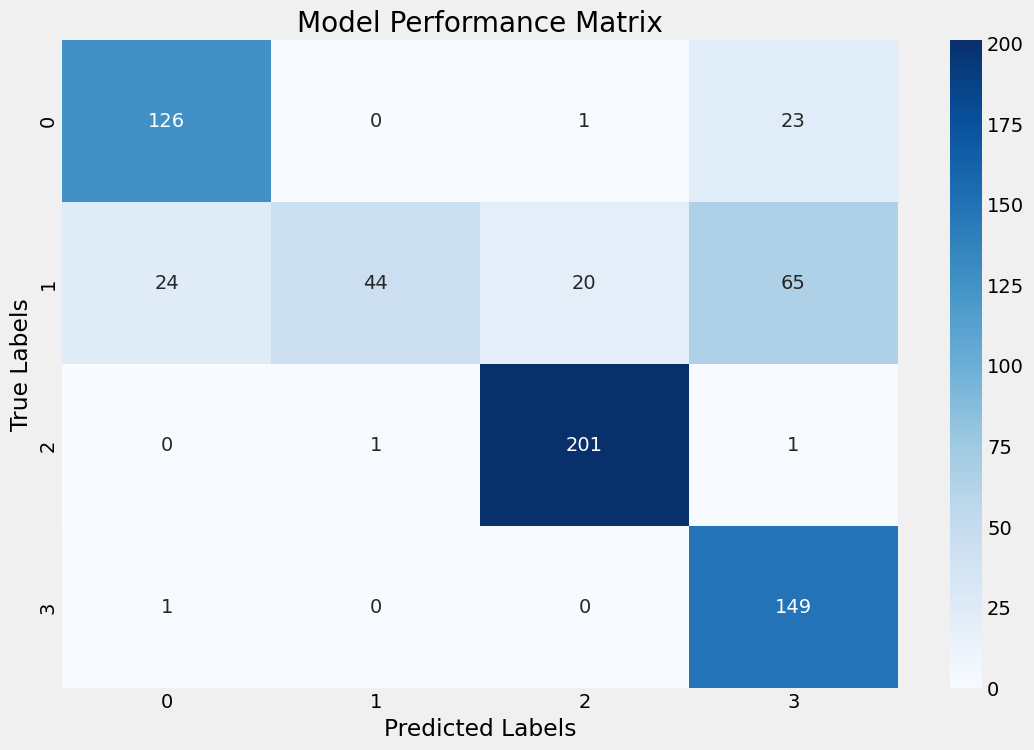

In [19]:
# Create a confusion matrix to investigate the scenarios where the model
# performs best and identify areas of improvement.

preds = custom_model.predict(testing_gen)
# choose the highest probability class
y_pred = np.argmax(preds, axis=1)

# Map the classes to numerical categories, as the model understands numerical
# class labels.

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}

# Create and display the confusion matrix.

conf_matrix = confusion_matrix(testing_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(12,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Model Performance Matrix')
plt.show()


In [20]:
# Define a function to visualize custom model predictions on some example images

from PIL import Image

def predict(image_path: str) -> None:
    # Get class labels
    labels = list(class_dict.keys())

    # Create figure
    plt.figure(figsize=(6,8))

    # Load and preprocess input image

    image = Image.open(image_path)
    resized_image = image.resize((224,224))

    image_array = np.asarray(resized_image)
    image_array = np.expand_dims(image_array, axis=0) / 255.0

    # Retrieve model predictions
    predictions = custom_model.predict(image_array)
    probabilities = list(predictions[0])

    # Retrieve predicted classes
    predicted_class_index = np.argmax(probabilities)
    predicted_class = class_dict[predicted_class_index]

    # Plot input image
    plt.subplot(2,1,1)
    plt.imshow(resized_image)
    plt.title(f'Input MRI image \nPredicted class: {predicted_class}')

    # Plot prediction proabilities achieved
    plt.subplot(2,1,2)
    bars = plt.barh(labels, probabilities)
    plt.xlabel("Probabilites", fontsize=15)
    plt.title("Class Probabilities")

    # Add probability labels to bars
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.2f')

    plt.tight_layout()
    plt.show()

    print(f"Predicted tumor type: {predicted_class}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


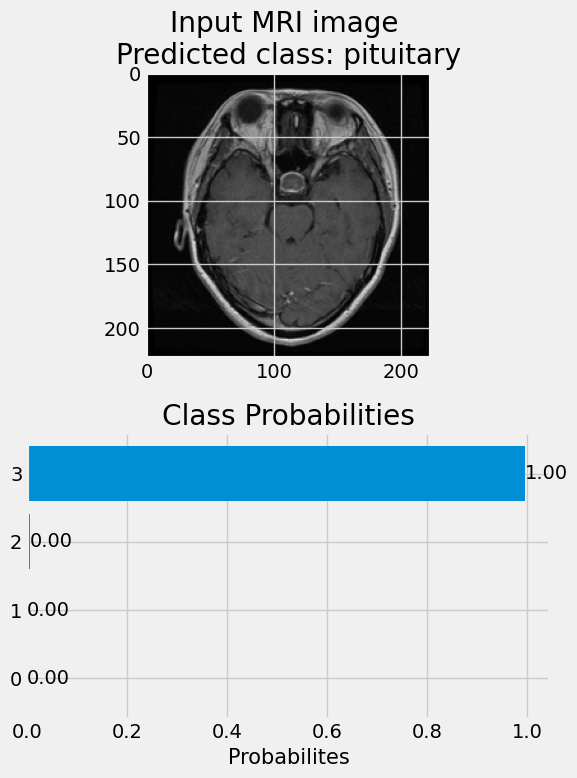

Predicted tumor type: pituitary


In [21]:
# Testing
predict("/content/Training/pituitary/Tr-piTr_0001.jpg")

In [22]:
cl_report = classification_report(testing_gen.classes, y_pred)
print(cl_report)

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       150
           1       0.98      0.29      0.44       153
           2       0.91      0.99      0.95       203
           3       0.63      0.99      0.77       150

    accuracy                           0.79       656
   macro avg       0.84      0.78      0.75       656
weighted avg       0.84      0.79      0.76       656



In [23]:
custom_model.save('data_augmented_cnn_model_final.h5')